# Zipf-aware wave tokenization (word-level) quick viz

This notebook demo assigns per-token wave frequencies from word Zipf ranks (with per-query mixing), builds simple wave embeddings, and visualizes frequency bands and a toy attention superposition.

Steps:
1. Word-aware frequency assignment per query
2. Wave embedding preview (harmonic sin/cos)
3. Band/bucket view
4. Toy attention heatmap + entropy

Outputs are also saved as PNG under `figs/` for quick inspection.



In [1]:
import math
from pathlib import Path
from typing import List, Dict

import torch
import matplotlib.pyplot as plt
import numpy as np

# Self-contained word-aware frequency assigner (no external import)
from dataclasses import dataclass
from collections import Counter

@dataclass
class WordFreqConfig:
    vocab_size_words: int
    freq_min: float = 0.0
    freq_max: float = 1.0
    mix_weight: float = 0.7  # weight on global rank vs local rank

    def validate(self) -> bool:
        assert self.vocab_size_words > 0, "vocab_size_words must be positive"
        assert 0.0 <= self.freq_min < self.freq_max <= 1.0, "freq_min/freq_max must satisfy 0 <= min < max <= 1"
        assert 0.0 <= self.mix_weight <= 1.0, "mix_weight must be in [0,1]"
        return True

class WordFrequencyAssigner:
    def __init__(self, tokenizer, word_rank_table: Dict[str, int], config: WordFreqConfig) -> None:
        self.tokenizer = tokenizer
        self.word_rank_table = word_rank_table
        self.config = config
        self.config.validate()

    def _word_ranks(self, words: List[str]) -> List[int]:
        default_rank = self.config.vocab_size_words  # rarest fallback
        return [self.word_rank_table.get(w, default_rank) for w in words]

    def _local_ranks(self, words: List[str]) -> List[int]:
        counts = Counter(words)
        sorted_words = sorted(counts.items(), key=lambda x: (-x[1], x[0]))
        local_rank_map = {w: i for i, (w, _) in enumerate(sorted_words, start=1)}
        return [local_rank_map[w] for w in words]

    def _mix_ranks(self, global_rank: int, local_rank: int) -> float:
        a = self.config.mix_weight
        return (global_rank ** a) * (local_rank ** (1.0 - a))

    def _rank_to_freq(self, rank: torch.Tensor) -> torch.Tensor:
        log_v = torch.log(torch.tensor(float(self.config.vocab_size_words)))
        norm = torch.log(rank) / log_v
        return self.config.freq_min + (self.config.freq_max - self.config.freq_min) * norm

    def assign(self, text: str):
        encoded = self.tokenizer.encode_plus(text, return_offsets_mapping=True, add_special_tokens=False)
        token_ids = torch.tensor(encoded["input_ids"], dtype=torch.long)
        offsets = encoded["offset_mapping"]
        words: List[str] = []
        token_to_word: List[int] = []
        prev_end = -1
        word_idx = -1
        for (start, end) in offsets:
            if start == prev_end:
                token_to_word.append(word_idx)
            else:
                word_idx += 1
                token_to_word.append(word_idx)
                words.append(text[start:end])
            prev_end = end
        global_ranks = self._word_ranks(words)
        local_ranks = self._local_ranks(words)
        eff_ranks = [self._mix_ranks(g, l) for g, l in zip(global_ranks, local_ranks)]
        rank_tensor = torch.tensor([eff_ranks[idx] for idx in token_to_word], dtype=torch.float32)
        freqs = self._rank_to_freq(rank_tensor)
        return token_ids, freqs

# Figure directory
NOTEBOOK_DIR = Path.cwd()
FIG_DIR = NOTEBOOK_DIR / "figs"
FIG_DIR.mkdir(exist_ok=True)

# Lightweight whitespace tokenizer with offsets compatible with WordFrequencyAssigner expectations
class WhiteSpaceTokenizer:
    def encode_plus(self, text: str, return_offsets_mapping=True, add_special_tokens=False):
        words = text.split()
        offsets = []
        input_ids = []
        pos = 0
        for w in words:
            start = text.find(w, pos)
            end = start + len(w)
            offsets.append((start, end))
            input_ids.append(hash(w) % 10000)  # fake token id
            pos = end
        return {"input_ids": input_ids, "offset_mapping": offsets}

# Example text and word rank table (mock Zipf ranks; 1 = most common)
text = (
    "On a windy hill a small observatory kept vigil each night, listening to whispers "
    "of meteors and distant storms. Mira adjusted brass gears, wound the ancient clock, "
    "and brewed coffee while charts fluttered like birds. A traveler arrived with a "
    "brittle map, promising a hidden tower where books hummed and time bent. Mira packed "
    "tools, lantern, and a curious heart, crossed stone bridges at dawn, found the ivy "
    "door ajar, and heard pages rustle like thunder."
)

# Mock global word ranks (short list; unseen words default to rare)
word_ranks: Dict[str, int] = {
    "on": 20,
    "a": 10,
    "windy": 2000,
    "hill": 1800,
    "small": 800,
    "observatory": 4000,
    "kept": 700,
    "vigil": 3000,
    "each": 200,
    "night": 300,
    "listening": 900,
    "to": 15,
    "whispers": 1600,
    "of": 12,
    "meteors": 4200,
    "and": 5,
    "distant": 2500,
    "storms": 4200,
    "mira": 7000,
    "adjusted": 2600,
    "brass": 3000,
    "gears": 2600,
    "wound": 4800,
    "the": 1,
    "ancient": 2000,
    "clock": 1400,
    "brewed": 2300,
    "coffee": 1900,
    "while": 150,
    "charts": 2600,
    "fluttered": 3600,
    "like": 90,
    "birds": 1200,
    "traveler": 3300,
    "arrived": 600,
    "with": 30,
    "brittle": 5200,
    "map": 1750,
    "promising": 2600,
    "hidden": 2300,
    "tower": 1500,
    "where": 70,
    "books": 900,
    "hummed": 5205,
    "time": 600,
    "bent": 2600,
    "packed": 2100,
    "tools": 1900,
    "lantern": 4000,
    "curious": 1900,
    "heart": 1600,
    "crossed": 1900,
    "stone": 1700,
    "bridges": 2600,
    "at": 40,
    "dawn": 2000,
    "found": 900,
    "ivy": 5209,
    "door": 1800,
    "ajar": 5210,
    "heard": 800,
    "pages": 2000,
    "rustle": 4200,
    "thunder": 2500,
}

config = WordFreqConfig(vocab_size_words=60000, freq_min=0.0, freq_max=1.0, mix_weight=0.7)
tokenizer = WhiteSpaceTokenizer()
assigner = WordFrequencyAssigner(tokenizer, word_ranks, config)

token_ids, freqs = assigner.assign(text)
positions = torch.arange(len(token_ids), dtype=torch.float32)

print("Tokens:", token_ids.tolist())
print("Freqs:", freqs.tolist())



Tokens: [538, 7689, 2214, 1870, 7689, 127, 6126, 8193, 4305, 1589, 1456, 553, 1445, 6096, 7104, 7053, 2667, 4495, 1675, 439, 5997, 2123, 5647, 6091, 8358, 4268, 758, 2667, 3940, 2724, 1875, 657, 3474, 8835, 7010, 4075, 8676, 5040, 7346, 7689, 4510, 3023, 7686, 7689, 2678, 1229, 7817, 2626, 5738, 2667, 3742, 459, 439, 8997, 1790, 2409, 2667, 7689, 2249, 9363, 8105, 4697, 3841, 511, 886, 4838, 8358, 5957, 6531, 8010, 2667, 1953, 4807, 6923, 8835, 1556]
Freqs: [0.7530601620674133, 0.14650017023086548, 0.5965744853019714, 0.5738435387611389, 0.14650017023086548, 0.5319743752479553, 0.6308878660202026, 0.5159953236579895, 0.6205832362174988, 0.4279622733592987, 0.8025586009025574, 0.5333836078643799, 0.28156760334968567, 0.5819408893585205, 0.2618984878063202, 0.6327236294746399, 0.1212996393442154, 0.5866390466690063, 0.8077405691146851, 0.7299564480781555, 0.5569953918457031, 0.5850005149841309, 0.7936362624168396, 0.6531276702880859, 0.04388538375496864, 0.546387255191803, 0.783016562461

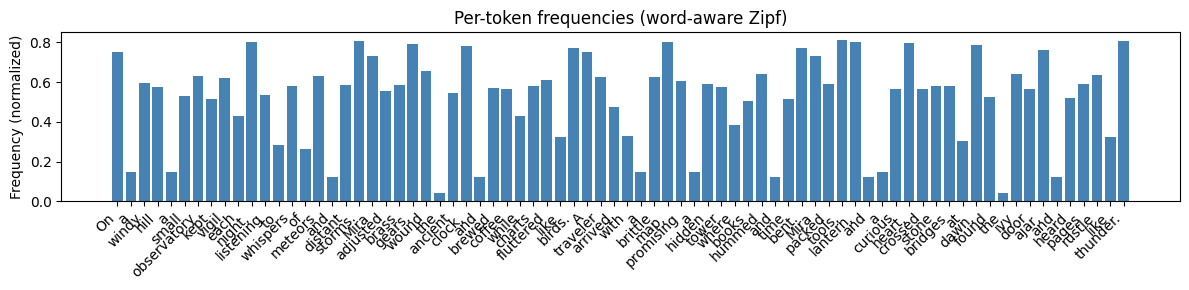

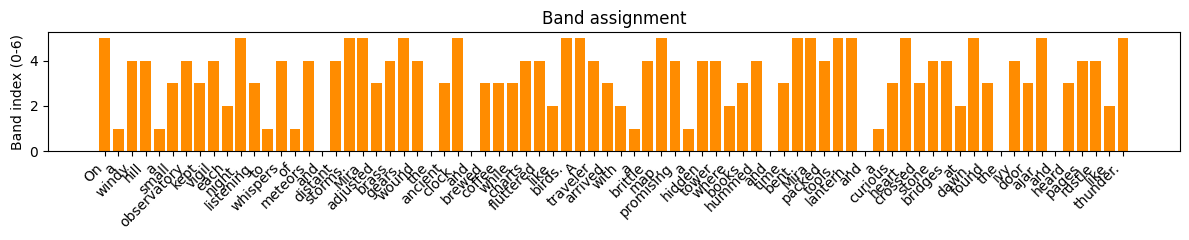

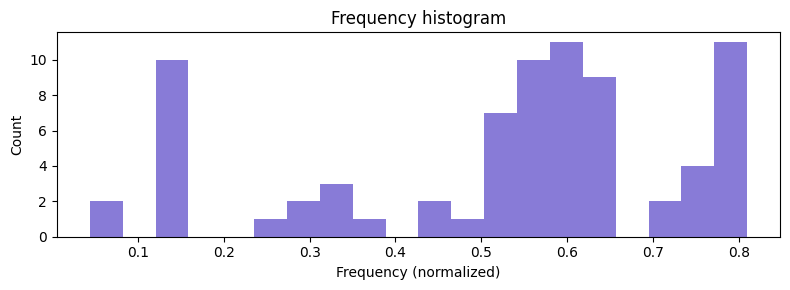

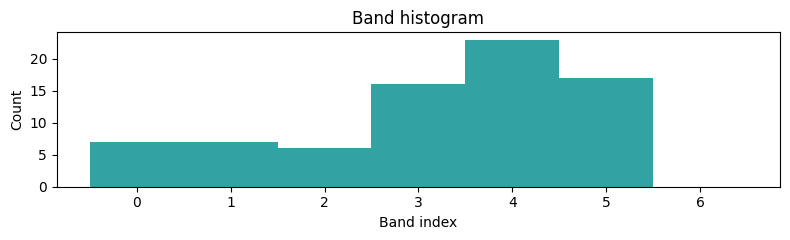

In [2]:
# Band assignment and frequency plot
words = text.split()
num_bands = 7
band_edges = torch.linspace(config.freq_min, config.freq_max, num_bands + 1)
band_ids = torch.bucketize(freqs, band_edges) - 1  # 0-based

plt.figure(figsize=(12, 3))
plt.bar(range(len(freqs)), freqs.numpy(), color="steelblue")
plt.xticks(range(len(freqs)), words, rotation=45, ha="right")
plt.ylabel("Frequency (normalized)")
plt.title("Per-token frequencies (word-aware Zipf)")
plt.tight_layout()
plt.savefig(FIG_DIR / "freqs.png", dpi=150)
plt.show()

plt.figure(figsize=(12, 2.5))
plt.bar(range(len(band_ids)), band_ids.numpy(), color="darkorange")
plt.xticks(range(len(freqs)), words, rotation=45, ha="right")
plt.ylabel("Band index (0-6)")
plt.title("Band assignment")
plt.tight_layout()
plt.savefig(FIG_DIR / "bands.png", dpi=150)
plt.show()

# Histogram of frequencies and bands
plt.figure(figsize=(8, 3))
plt.hist(freqs.numpy(), bins=20, color="slateblue", alpha=0.8)
plt.xlabel("Frequency (normalized)")
plt.ylabel("Count")
plt.title("Frequency histogram")
plt.tight_layout()
plt.savefig(FIG_DIR / "freq_hist.png", dpi=150)
plt.show()

plt.figure(figsize=(8, 2.5))
plt.hist(band_ids.numpy(), bins=num_bands, range=(-0.5, num_bands - 0.5), color="darkcyan", alpha=0.8)
plt.xlabel("Band index")
plt.ylabel("Count")
plt.title("Band histogram")
plt.tight_layout()
plt.savefig(FIG_DIR / "band_hist.png", dpi=150)
plt.show()



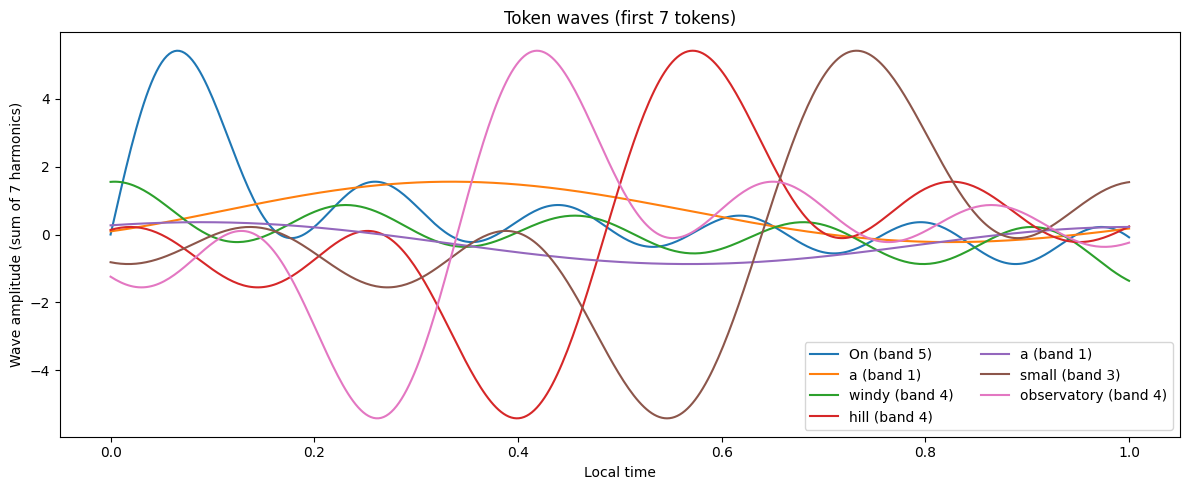

In [3]:
# Wave embedding preview (simple sin/cos, 7 harmonics)
harmonics = torch.arange(1, 8, dtype=torch.float32)

t_local = torch.linspace(0, 1, 400)
plt.figure(figsize=(12, 5))
for i in range(min(7, len(freqs))):
    f = freqs[i]
    p = positions[i]
    wave = torch.zeros_like(t_local)
    for h in harmonics:
        wave = wave + torch.sin(2 * math.pi * f * h * (p + t_local))
    plt.plot(t_local.numpy(), wave.numpy(), label=f"{words[i]} (band {band_ids[i].item()})")
plt.xlabel("Local time")
plt.ylabel("Wave amplitude (sum of 7 harmonics)")
plt.title("Token waves (first 7 tokens)")
plt.legend(ncol=2)
plt.tight_layout()
plt.savefig(FIG_DIR / "waves.png", dpi=150)
plt.show()



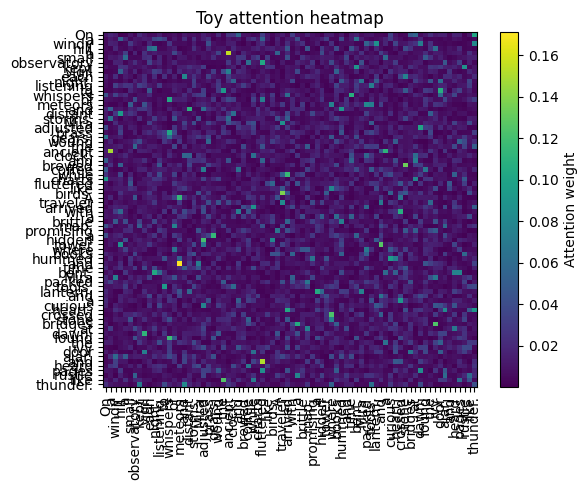

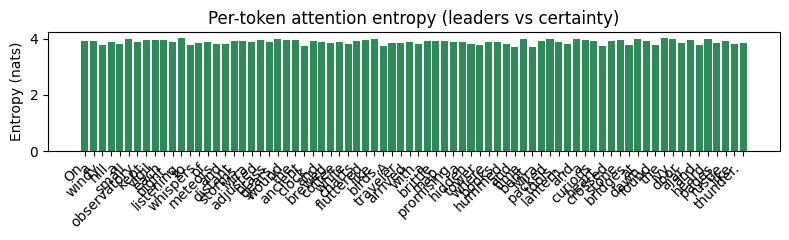

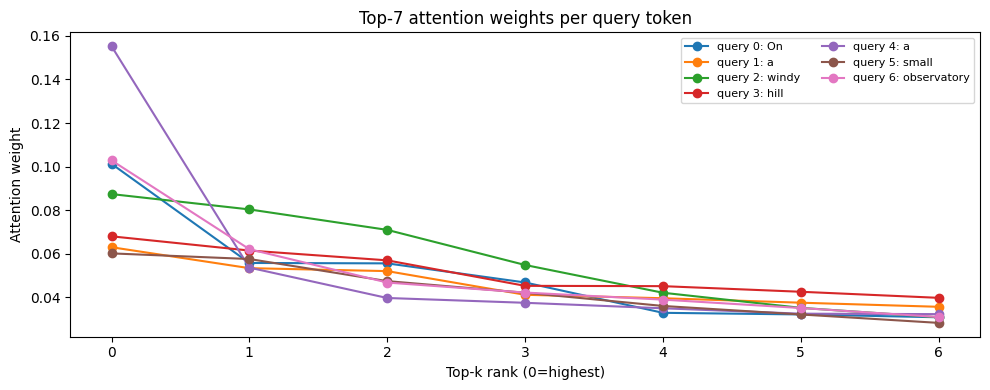

Saved results to /content/figs/results.json


In [4]:
# Toy attention superposition and entropy
import json

seq_len = len(freqs)
logits = torch.randn(seq_len, seq_len)
attn = torch.softmax(logits, dim=-1)

entropy = -(attn * (attn.clamp(min=1e-9).log())).sum(dim=-1)

plt.figure(figsize=(6, 5))
plt.imshow(attn.numpy(), cmap="viridis", aspect="auto")
plt.colorbar(label="Attention weight")
plt.xticks(range(seq_len), words, rotation=90)
plt.yticks(range(seq_len), words)
plt.title("Toy attention heatmap")
plt.tight_layout()
plt.savefig(FIG_DIR / "attention_heatmap.png", dpi=150)
plt.show()

plt.figure(figsize=(8, 2.5))
plt.bar(range(seq_len), entropy.numpy(), color="seagreen")
plt.xticks(range(seq_len), words, rotation=45, ha="right")
plt.ylabel("Entropy (nats)")
plt.title("Per-token attention entropy (leaders vs certainty)")
plt.tight_layout()
plt.savefig(FIG_DIR / "attention_entropy.png", dpi=150)
plt.show()

# Top-7 attended tokens per query position (arg top-k over rows)
top_k = 7
top_vals, top_idx = torch.topk(attn, k=min(top_k, seq_len), dim=-1)

plt.figure(figsize=(10, 4))
for i in range(min(7, seq_len)):
    plt.plot(range(top_vals.size(1)), top_vals[i].numpy(), marker="o", label=f"query {i}: {words[i]}")
plt.xlabel("Top-k rank (0=highest)")
plt.ylabel("Attention weight")
plt.title("Top-7 attention weights per query token")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.savefig(FIG_DIR / "attention_topk_weights.png", dpi=150)
plt.show()

# Save key results to JSON
results = {
    "text": text,
    "token_ids": token_ids.tolist(),
    "freqs": freqs.tolist(),
    "band_ids": band_ids.tolist(),
    "attention_entropy": entropy.tolist(),
    "attention_top_vals": top_vals.tolist(),
    "attention_top_idx": top_idx.tolist(),
}
with open(FIG_DIR / "results.json", "w") as f:
    json.dump(results, f, indent=2)
print("Saved results to", FIG_DIR / "results.json")



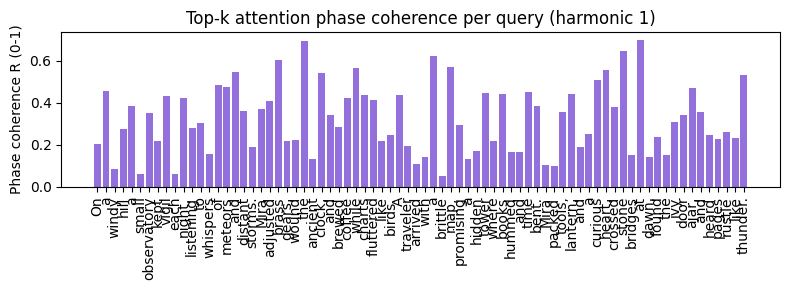

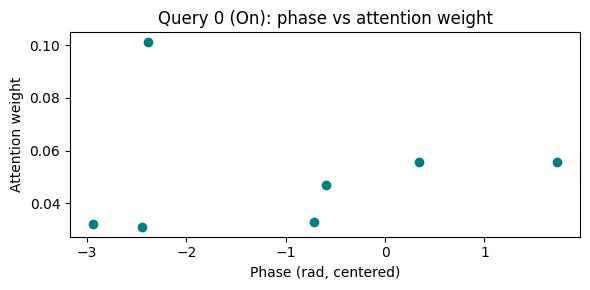

Updated results with phase coherence -> /content/figs/results.json


In [5]:
# Phase coherence through the attention lens
# Use harmonic 1 phase at t=0: phi = 2π f * position
harmonic = 1.0
phi_all = 2 * math.pi * freqs * positions  # [T]

# Compute coherence R per query over its top-k attended tokens
R_per_query = []
for i in range(seq_len):
    idx = top_idx[i]  # top-k indices for query i
    phi_top = phi_all[idx]
    R = torch.abs(torch.mean(torch.exp(1j * phi_top)))
    R_per_query.append(R.item())
R_per_query = torch.tensor(R_per_query)

plt.figure(figsize=(8, 3))
plt.bar(range(seq_len), R_per_query.numpy(), color="mediumpurple")
plt.xticks(range(seq_len), words, rotation=90)
plt.ylabel("Phase coherence R (0-1)")
plt.title("Top-k attention phase coherence per query (harmonic 1)")
plt.tight_layout()
plt.savefig(FIG_DIR / "attention_phase_coherence.png", dpi=150)
plt.show()

# Phase vs attention weight for a selected query (0) to see alignment of leaders
q = 0
phi_top_q = ((phi_all[top_idx[q]] + math.pi) % (2 * math.pi)) - math.pi
w_top_q = top_vals[q]

plt.figure(figsize=(6, 3))
plt.scatter(phi_top_q.numpy(), w_top_q.numpy(), color="teal")
plt.xlabel("Phase (rad, centered)")
plt.ylabel("Attention weight")
plt.title(f"Query {q} ({words[q]}): phase vs attention weight")
plt.tight_layout()
plt.savefig(FIG_DIR / "attention_phase_scatter_q0.png", dpi=150)
plt.show()

# Log into results
results["attention_phase_coherence"] = R_per_query.tolist()
with open(FIG_DIR / "results.json", "w") as f:
    json.dump(results, f, indent=2)
print("Updated results with phase coherence ->", FIG_DIR / "results.json")

